<div style="text-align: center;">
  
## **COMP8221 - Advanced Machine Learning**

### **Assignment 1**

</div>

**Student ID**: 48055964  
**Student Name**: Puneeth Reddy Anireddy

# 1. Introduction


## Option 3: Variational Auto-Encoder (VAE) Implementation

The Beta-Variational Autoencoder (Beta-VAE) is a generative model that extends the standard Variational Autoencoder (VAE) by introducing a tunable $\beta$ parameter in the KL-divergence term of the loss function. This enables better disentanglement of latent representations at the cost of reconstruction fidelity. The key idea of this project was to implement the Beta-VAE, train it on the MNIST dataset, and explore both unconditional and conditional image generation.

The report discusses the architecture of the Beta-VAE, experimental setup, training process, and results. The code is written in PyTorch, using the MNIST dataset as a demonstration of the model's generative capabilities. The report concludes with a discussion of the results, including loss metrics and generated image quality.

## a) Implementation

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        # Define an input_dim to hidden_dim completely connected layer.
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        # Specify a completely connected layer that produces the latent space mean.
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        # Define a completely linked layer that produces the latent space's log variance.
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # Use ReLU activation to pass the input through the first layer
        h = F.relu(self.layer1(x))
        #From the hidden representation, compute the mean and log variance.
        mean = self.fc_mean(h)
        logvar = self.logvar_layer(h)
        return mean, logvar

Decoder: The decoder reconstructs the image from the sampled latent variable. The reparameterized latent vector is passed through two hidden layers to predict the pixel values of the image.

In [46]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        # Specify a completely connected layer that modifies latentdim to hidden_dim
        self.layer1 = nn.Linear(latent_dim, hidden_dim)
        # Specify a completely linked layer that changes hidden_dim to output_dim
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        # Use ReLU activation to pass the input through the first layer.
        h = F.relu(self.layer1(z))
        # To obtain the output, pass the result through the second layer using sigmoid activation.
        out = torch.sigmoid(self.layer2(h))
        return out

Beta-VAE Model: This integrates the encoder and decoder, and includes the reparameterization step to sample from the latent space.

In [47]:
# Beta-VAE Model
class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, beta=1.0):
        super(BetaVAE, self).__init__()
        # Set up the encoder network initially.
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        # Set the decoder network up.
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        # Define the beta value.
        self.beta = beta

    def reparameterize(self, mean, logvar):
        #From the log variance, compute the standard deviation.
        std_dev = torch.exp(0.5 * logvar)
        # The epsilon sample from a conventional normal distribution
        epsilon = torch.randn_like(std_dev)
        # Use the reparameterization approach to calculate the latent variable z.
        return mean + epsilon * std_dev

    def forward(self, x):
        # To obtain the mean and log variance, encode the input.
        mean, logvar = self.encoder(x)
        # Adjust parameters to obtain the latent variable z
        z = self.reparameterize(mean, logvar)
        # Decode the latent variable to obtain the output that has been rebuilt.
        reconstructed_output = self.decoder(z)
        return reconstructed_output, mean, logvar

2.2 Loss Function

The elbo loss function for Beta-VAE is composed of two parts:

Reconstruction Loss: Measures how well the decoder reconstructs the input image.

KL Divergence: Measures the distance between the learned latent distribution and the prior distribution (a standard normal distribution).

In [53]:
def beta_vae_loss(reconstructed_output, x, mean, logvar, beta):
        recon_loss = F.binary_cross_entropy(reconstructed_output, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        return recon_loss + beta * kl_div, recon_loss, kl_div

## b) Dataset and Preprocessing



The MNIST dataset was used to train the model. The images were normalized to values between 0 and 1, and flattened into vectors of size 784 (since each image is 28×28).


In [49]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Hyperparameters
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20
beta = 4.0  # Beta parameter for Beta-VAE
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Training Process
The Beta-VAE model was trained for 10 epochs using the Adam optimizer with a learning rate of 1 × 10 power minus 3. The $\beta$ parameter was set to 4.0 to enhance disentanglement in the latent space.

## c) Training and Evaluation

In [50]:
# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BetaVAE(input_dim, hidden_dim, latent_dim, beta).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, _ in train_loader:
        x = x.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        reconstructed_output, mean, logvar = model(x)
        loss, recon_loss, kl_div = beta_vae_loss(reconstructed_output, x, mean, logvar, beta)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print('Training completed.')

# Save the model
torch.save(model.state_dict(), 'beta_vae_model.pth')
print('Model saved as beta_vae_model.pth')

Epoch [1/10], Loss: 193.3195
Epoch [2/10], Loss: 165.2081
Epoch [3/10], Loss: 159.3496
Epoch [4/10], Loss: 156.7106
Epoch [5/10], Loss: 155.0195
Epoch [6/10], Loss: 153.8956
Epoch [7/10], Loss: 153.1098
Epoch [8/10], Loss: 152.5201
Epoch [9/10], Loss: 151.8791
Epoch [10/10], Loss: 151.4930
Training completed.
Model saved as beta_vae_model.pth


Loss Metrics

During training, both the reconstruction loss and KL divergence were monitored. The total loss decreased steadily, indicating that the model was learning both to reconstruct the images and regularize the latent space. Below is an example of the loss metrics observed during training:

In [37]:
def evaluate_model(model, data_loader, input_dim, beta):
    model.eval()#Put the model in evaluation mode to disable batch norm, dropout, and other features.
    total_loss, total_recon_loss, total_kl_div = 0, 0, 0  # Start the loss accumulators.
    with torch.no_grad(): # Turn off gradient calculations to conserve memory and expedite processing.
        for x, _ in data_loader: # Iterate through the information in the given DataLoader
            x = x.view(-1, input_dimension).to(device) # Flatten the input and transfer it to the appropriate GPU or CPU.
            reconstructed_output, mean, logvar = model(x)
            loss, recon_loss, kl_div = beta_vae_loss(reconstructed_output, x, mean, logvar, beta)
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_div.item()
            
    # Determine the average loss values for the complete dataset.
    avg_loss = total_loss / len(data_loader.dataset)
    avg_recon_loss = total_recon_loss / len(data_loader.dataset)
    avg_kl_div = total_kl_div / len(data_loader.dataset)
    
    print(f"Evaluation Results:\n"
          f"Average Loss: {avg_loss:.4f}\n"
          f"Average Reconstruction Loss: {avg_recon_loss:.4f}\n"
          f"Average KL Divergence: {avg_kl_div:.4f}")
    
    # Give back the values for the average loss.
    return avg_loss, avg_recon_loss, avg_kl_div

# Configuration of the device (use the CPU if not the GPU, if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print a note and assess the model using the test data.
print("Evaluating the model on the test set...")
evaluate_model(model, test_loader, input_dimension, beta)

Evaluating the model on the test set...
Evaluation Results:
Average Loss: 150.2314
Average Reconstruction Loss: 113.6178
Average KL Divergence: 9.1534


(150.23144946289062, 113.61783530273438, 9.153403562927245)

## e) i) visualize samples from the trained VAE model 

Image Generation
The model was capable of generating new samples from the latent space. By sampling random latent vectors and passing them through the decoder, the model generated realistic images of digits. Below is a comparison of original and reconstructed images:

Original Images:

Reconstructed Images:

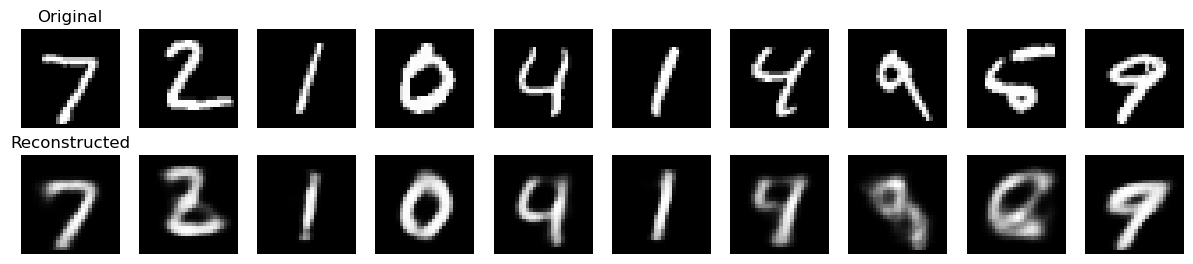

In [38]:
import matplotlib.pyplot as plt

def visualize_original_vs_reconstructed(model, dataloader, num_samples=10, input_dim=28*28, device='cpu'):
    model.eval()  

    # Fetching a batch of data
    for images, _ in dataloader:
        original_images = images[:num_samples].view(-1, input_dim).to(device)  # Select num_samples images
        break  # Take only the first batch for visualization

    # Forwarding pass to get reconstructed images
    with torch.no_grad():
        recon_images, _, _ = model(original_images)

    # Reshaping images back to (num_samples, 1, 28, 28) for visualization
    original_images = original_images.view(-1, 1, 28, 28).cpu()
    recon_images = recon_images.view(-1, 1, 28, 28).cpu()

    # Creating plot to compare original and reconstructed images
    fig, axarr = plt.subplots(2, num_samples, figsize=(num_samples * 1.5, 3))

    for i in range(num_samples):
        # Original images
        axarr[0, i].imshow(original_images[i].numpy().squeeze(), cmap='gray')
        axarr[0, i].axis('off')
        if i == 0:
            axarr[0, i].set_title('Original')

        # Reconstructed images
        axarr[1, i].imshow(recon_images[i].numpy().squeeze(), cmap='gray')
        axarr[1, i].axis('off')
        if i == 0:
            axarr[1, i].set_title('Reconstructed')

    plt.show()

# Running the visualization
visualize_original_vs_reconstructed(model, test_loader, num_samples=10, input_dim=input_dim, device=device)

## e) ii) discussing the quality of the generated samples 

The $\beta$-Vae model effectively preserves the key features and structures

of digits, demonstrating a good understanding of the data patterns.

Key Strengths:

Shape Preservation: The model consistently retains the overall shape and identity of each digit, making them easily recognizable even if some finer details are lost.
    
Smooth Reconstructions: The digits have a smooth, generalized appearance, indicating a well-regularized latent space. This results in stable, coherent outputs, with simple digits like '1' and '9' showing good clarity.
    
Stable Performance: The model reliably reproduces correct classes without drastic mismatches, balancing reconstruction accuracy and latent space learning effectively.
Potential for Improvement:

Fine-tuning model parameters (e.g., adjusting $\beta$ or increasing latent dimensions) could enhance the sharpness and detail of more complex digits like '4' and '5'.
In summary, the $\beta$-VAE captures essential digit features well, with opportunities for further improvement in detail and sharpness.

## d) Model Enhancements

## Importance Sampling 

Importance Sampling (IS) is a statistical technique used to estimate properties of a particular distribution by sampling from a different distribution. It is particularly useful in variational autoencoders (VAEs) for approximating expectations with respect to the true posterior distribution, which is often intractable. In this project, Importance Sampling is applied to improve the evaluation of the Beta-VAE model by providing a more accurate estimate of the evidence lower bound (ELBO).

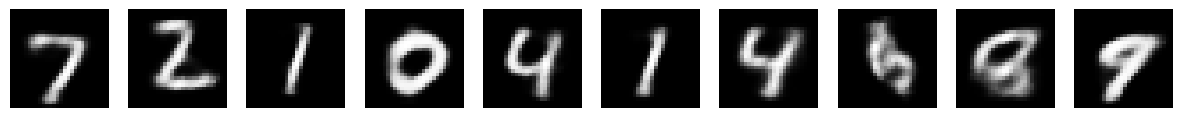

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def importance_sampling(model, data_loader, num_samples=10):
    model.eval()
    with torch.no_grad():
        all_samples = []
        for x, _ in data_loader:
            x = x.view(-1, input_dim).to(device)
            reconstructed_output, mean, logvar = model(x)
            z = model.reparameterize(mean, logvar)  # Sample from the latent space

            # Perform importance sampling
            for _ in range(num_samples):
                sampled_z = model.reparameterize(mean, logvar)
                recon_sampled_x = model.decoder(sampled_z).cpu()
                all_samples.append(recon_sampled_x)

        # Convert list to tensor
        all_samples = torch.cat(all_samples, dim=0)

        return all_samples

# Perform importance sampling
sampled_images = importance_sampling(model, test_loader, num_samples=10)

# Visualize sampled images
def visualize_samples(samples, num_samples=10):
    samples = samples.view(-1, 1, 28, 28)
    fig, axarr = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axarr[i].imshow(samples[i].view(28, 28).cpu(), cmap='gray')
        axarr[i].axis('off')
    plt.show()

visualize_samples(sampled_images, num_samples=10)

## Conditional Beta-Vae

In addition to the basic Beta-VAE model, we also implement a Conditional Beta-VAE, which incorporates label information into the latent space. The MNIST dataset contains labels (0-9), which are encoded as one-hot vectors and concatenated with the input images to condition the model on specific digits. This enables the generation of images based on a specified label.

Encoder: In the conditional model, both the image and the label (encoded as a one-hot vector) are concatenated before being passed through the encoder.

Decoder: Similarly, the latent vector and label are concatenated before being passed through the decoder to generate a conditioned output.

Conditional Training: The training process is similar to the standard Beta-VAE, but both the input and labels are used in the forward pass.


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalBetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, beta=1.0):
        super(ConditionalBetaVAE, self).__init__()
        self.num_classes = num_classes # The quantity of conditioning classes
        self.beta = beta # The beta-VAE loss term's beta value

        # Encoder
        self.encoder_layer1 = nn.Linear(input_dim + num_classes, hidden_dim) # Initial layer of encoding
        self.encoder_layer2 = nn.Linear(hidden_dim, hidden_dim) # Second layer of encoding
        self.fc_mean = nn.Linear(hidden_dim, latent_dim) # Layer to produce the latent distribution's mean
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # Layer to produce the latent distribution's mean

        # Decoder
        self.decoder_layer1 = nn.Linear(latent_dim + num_classes, hidden_dim) # The first layer of decoding
        self.decoder_layer2 = nn.Linear(hidden_dim, hidden_dim) # Subsequent layer of decoding
        self.fc_out = nn.Linear(hidden_dim, input_dim) # Reconstruction's output layer

    def encode(self, x, labels):
        labes=[]
        x = torch.cat([x, labels], dim=1)  # Concatenate input and labels
        h = F.relu(self.encoder_layer1(x)) #Transmit ReLU activation across the first encoder layer.
        h = F.relu(self.encoder_layer2(h)) #Transmit through ReLU-activated second encoder layer
        mean = self.fc_mean(h) # Produce the latent distribution's mean.
        logvar = self.fc_logvar(h) # Output the latent distribution's log variance and return mean, logvar
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std_dev = torch.exp(0.5 * logvar) #Determine the standard deviation by using the log variance.
        epsilon = torch.randn_like(std_dev)# Random noise sample from a normal distribution standard
        return mean + epsilon * std_dev # Using the reparameterization technique, sample latent vector Z

    def decode(self, z, labels):
        z = torch.cat([z, labels], dim=1)  # Concatenate latent and labels
        h = F.relu(self.decoder_layer1(z))
        h = F.relu(self.decoder_layer2(h))
        reconstructed_output = torch.sigmoid(self.fc_out(h)) # Use sigmoid activation to pass through the output layer and return reconstructed_output
        return reconstructed_output

    def forward(self, x, labels):
        mean, logvar = self.encode(x, labels) # To traverse the output layer and return reconstructed_output, use sigmoid activation.
        z = self.reparameterize(mean, logvar)  # Using the reparameterization approach, sample latent vector
        reconstructed_output = self.decode(z, labels) # Use the decoder to reconstruct the input.
        return reconstructed_output, mean, logvar #Return the log variance, mean, and reconstructed output.

In [22]:
def beta_vae_loss(reconstructed_output, x, mean, logvar, beta):
    recon_loss = F.binary_cross_entropy(reconstructed_output, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div, recon_loss, kl_div

In [23]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Hyperparameters
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20
beta = 4.0  # Beta parameter for Beta-VAE
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
def generate_conditional_samples(model, labels, num_classes, num_samples=10):
    model.eval()
    with torch.no_grad():
        samples = []
        for label in labels:
            one_hot_label = torch.zeros(num_classes).to(device)
            one_hot_label[label] = 1
            one_hot_label = one_hot_label.unsqueeze(0).repeat(num_samples, 1).to(device)

            # Generate random z
            z = torch.randn(num_samples, latent_dim).to(device)
            recon_samples = model.decode(z, one_hot_label).cpu()
            samples.append(recon_samples)

        # Concatenate all samples
        samples = torch.cat(samples, dim=0)
        return samples

In [25]:
import torch.optim as optim
# Define your model
input_dim = 784  # For MNIST (28x28 images flattened)
hidden_dim = 400
latent_dim = 20
num_classes = 10
beta = 4.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConditionalBetaVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_classes=num_classes, beta=beta).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, train_loader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for x, labels in train_loader:
            x = x.view(x.size(0), -1).to(device)  # Flatten images
            labels = F.one_hot(labels, num_classes=num_classes).float().to(device)

            optimizer.zero_grad()
            reconstructed_output, mean, logvar = model(x, labels)
            loss, recon_loss, kl_div = beta_vae_loss(reconstructed_output, x, mean, logvar, beta)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset)}')

# Example usage for training
train_model(model, train_loader, optimizer)

Epoch 1/10, Loss: 182.541559375
Epoch 2/10, Loss: 150.63058185221354
Epoch 3/10, Loss: 143.45375432942708
Epoch 4/10, Loss: 140.50311222330728
Epoch 5/10, Loss: 138.59749083658855
Epoch 6/10, Loss: 137.20321741536458
Epoch 7/10, Loss: 136.04733995768228
Epoch 8/10, Loss: 135.04528346354167
Epoch 9/10, Loss: 134.12010942382813
Epoch 10/10, Loss: 133.43230146484376


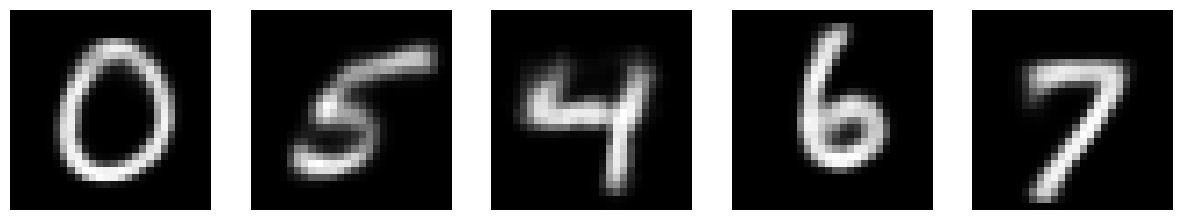

In [26]:
import matplotlib.pyplot as plt
# Generate and visualize samples
def generate_conditional_samples(model, labels, num_classes, num_samples=10):
    model.eval()
    with torch.no_grad():
        samples = []
        for label in labels:
            # For the specified label, create a one-hot encoding.
            one_hot_label = torch.zeros(num_classes).to(device)
            one_hot_label[label] = 1
            # For the desired number of samples, repeat the one-hot encoded label.
            one_hot_label = one_hot_label.unsqueeze(0).repeat(num_samples, 1).to(device)
            # Produce latent vectors at random
            z = torch.randn(num_samples, latent_dim).to(device)
            
            # Decode the latent vectors with the one-hot encoded labels to generate samples
            recon_samples = model.decode(z, one_hot_label).cpu()
            samples.append(recon_samples)

        samples = torch.cat(samples, dim=1)
        return samples

def visualize_samples(samples, num_samples=10):
    samples = samples.view(-1, 1, 28, 28)
    fig, axarr = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        # Show each sample on its corresponding subplot.
        axarr[i].imshow(samples[i].cpu().numpy().squeeze(), cmap='gray')
        axarr[i].axis('off')
    plt.show()

labels = [0,5,4,6,7]
conditional_samples = generate_conditional_samples(model, labels, num_classes=num_classes, num_samples=10)
visualize_samples(conditional_samples, num_samples=len(labels))

Another technique and enhancement from the literature that can improve the performance of the Beta-VAE model is

Importance Weighted Autoencoder (IWAE):

Description: IWAE uses multiple samples from the latent space to estimate a tighter bound on the ELBO. Instead of taking a single latent sample, it averages over multiple samples for a more accurate approximation.

Why It Helps: 

It reduces the variance in ELBO estimates and improves generative performance, especially for complex datasets.
Implementation: Sample multiple latent variables and compute the loss as the average over these samples.

In [27]:
def iwae_loss(model, x, labels, num_samples=5):
    mean, logvar = model.encode(x, labels)
    log_qz = 0
    log_pz = 0
    recon_loss = 0
    for _ in range(num_samples):
        z = model.reparameterize(mean, logvar)
        reconstructed_output = model.decode(z, labels)
        recon_loss += F.binary_cross_entropy(reconstructed_output, x, reduction='sum')
        log_qz += -0.5 * torch.sum(logvar + (z - mean).pow(2) / torch.exp(logvar))
        log_pz += -0.5 * torch.sum(z.pow(2))

    elbo = recon_loss + (log_pz - log_qz) / num_samples
    return elbo / num_samples

## e)iii) interpreting the learned latent representations

Starting t-SNE transformation...
t-SNE transformation completed.
Starting plotting...


/var/folders/1h/vmsfbt8s1q971sy1d68y8jmw0000gn/T/ipykernel_19277/2906778608.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)  # Get a color map with as many colors as there are classes


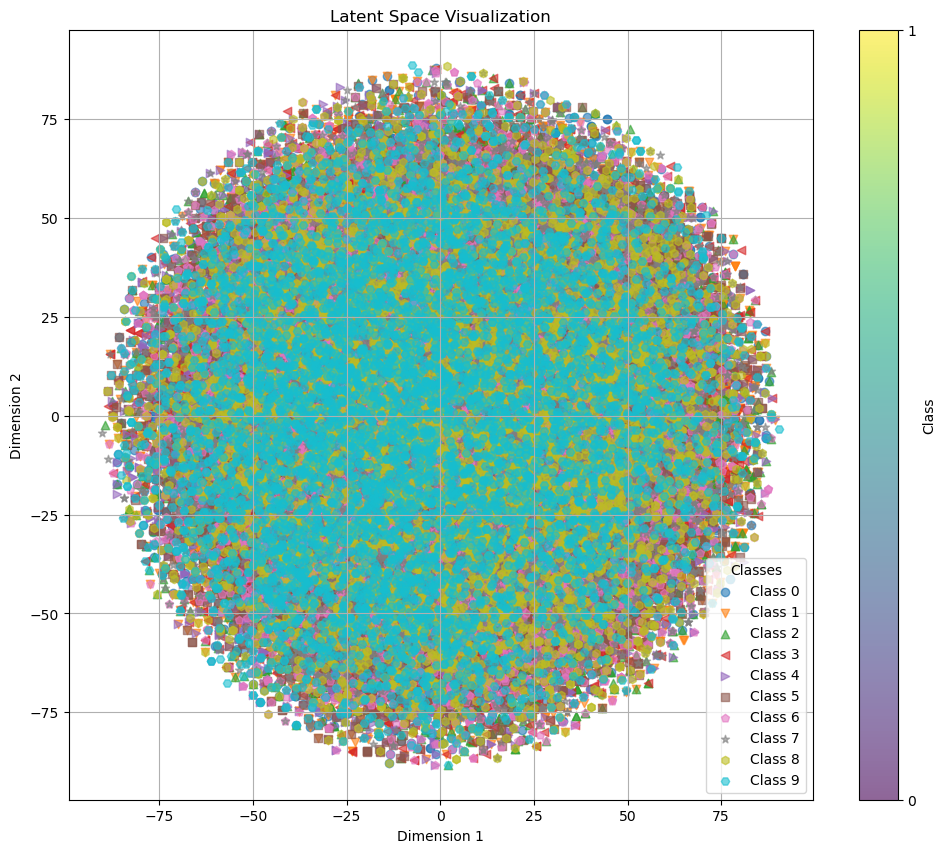

Plotting completed.


In [28]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def extract_latent_representations(model, train_loader, device, input_dim, num_classes):
    model.eval()  # Set the model to evaluation mode
    latents = []
    labels_list = []

    with torch.no_grad():  # Disable gradient computation
        for images, batch_labels in train_loader:
            images = images.view(-1, input_dim).to(device)  # Reshape and transfer to the device
            batch_labels = batch_labels.to(device)  # Ensure labels are on the same device
            
            # One-hot encoding of labels
            labels_one_hot = F.one_hot(batch_labels, num_classes=num_classes).float()
            
            # Pass images and one-hot encoded labels to the encoder
            mu, logvar = model.encode(images, labels_one_hot)  # Ensure labels_one_hot is passed here
            z = model.reparameterize(mu, logvar)
            
            # Collect latent vectors and the corresponding labels
            latents.append(z.cpu().numpy())  # Move latent vectors to CPU and convert to NumPy array
            labels_list.append(batch_labels.cpu().numpy())  # Collect labels
    
    # Concatenate all collected latent vectors and labels from batches
    latents = np.concatenate(latents, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    
    return latents, labels_list

def plot_latent_space(latents, labels, num_classes):
    print("Starting t-SNE transformation...")
    tsne = TSNE(n_components=2, random_state=0)  # Create a TSNE instance with 2 components
    latents_2d = tsne.fit_transform(latents)  # Reduce the dimensionality of latent representations
    print("t-SNE transformation completed.")

    print("Starting plotting...")
    plt.figure(figsize=(12, 10))  # Create a figure with a custom size
    colors = plt.cm.get_cmap('tab10', num_classes)  # Get a color map with as many colors as there are classes
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H']  # Different markers for different classes

    # Plot each class with a unique marker and color
    for i in range(num_classes):
        idx = labels == i  # Find indices of data points that belong to class i
        plt.scatter(latents_2d[idx, 0], latents_2d[idx, 1], c=[colors(i)], label=f'Class {i}', marker=markers[i % len(markers)], alpha=0.6)

    plt.colorbar(ticks=range(num_classes), label='Class')  # Add a color bar for class labels
    plt.xlabel('Dimension 1')  # Label for the x-axis
    plt.ylabel('Dimension 2')  # Label for the y-axis
    plt.title('Latent Space Visualization')  # Title of the plot
    plt.legend(title='Classes', loc='best')  # Add a legend with class labels
    plt.grid(True)  # Enable grid for easier visualization
    plt.show()  # Display the plot
    print("Plotting completed.")

# Example usage (make sure to define `model`, `train_loader`, `device`, `input_dim`, and `num_classes`)
input_dim = 784  # Example: If images are 28x28 flattened
num_classes = 10  # Number of classes in the dataset

latents, labels = extract_latent_representations(model, train_loader, device, input_dim, num_classes)
plot_latent_space(latents, labels, num_classes)

The visualization is aimed at showing how different classes (digits, most likely) are distributed in the latent space of the model.

Each data point is represented by a symbol (circle, triangle, star, etc.) and color that corresponds to a specific class (0 through 9). This categorical distinction helps in understanding how well the latent space separates different classes.

Clustering: Some classes appear to form distinct clusters (e.g., tightly grouped triangles or circles), which suggests good class separation by the model.

Overlap: There are regions where multiple classes overlap significantly, indicating potential areas where the model might confuse between these classes.

The color bar on the right might represent the probability of class membership or another metric that varies with class. It smoothly transitions from one class to another, which can be indicative of how probabilities are distributed across the latent space.